<a href="https://colab.research.google.com/github/tombackert/ml-stuff/blob/main/lime-paper-implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIME using Paper Implementation  


In [1]:
!pip install lime

In [2]:
# Imports
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import os, json

import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torch.autograd import Variable
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [3]:
# Fuction for reading in the images
def get_image(path):
  with open(os.path.abspath(path), 'rb') as f:
    with Image.open(f) as img:
      return img.convert('RGB')

In [4]:
# Paths to images
root = '/content/drive/MyDrive/lime-sample-data/'

names = ['./elephant.jpg',
         './dog-and-cat.jpg',
         './dog.jpg',
         './elefant-kilimandscharo.jpg',
         './kilimandscharo-giraffen.jpg',
         './964-turbo.jpg',
         './dtm-cars.jpg',
         './dtm-cars2.jpg',
         './paris.jpg',
         './sailboat-st-tropez.jpg',
         './sailboat-st-tropez2.jpg',
         './sailboat-ibiza.jpg']

paths = [os.path.join(root, name) for name in names]

images = [get_image(path) for path in paths]

In [5]:
print(len(images))

12


In [6]:
def show_images(images):
  num_images = len(images)
  num_cols = 3
  num_rows = (num_images + num_cols - 1) // num_cols

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

  for i, img in enumerate(images):
      row = i // num_cols
      col = i % num_cols

      axes[row, col].imshow(img)
      axes[row, col].set_title(f'Image {i+1}')
      axes[row, col].axis('off')

  plt.tight_layout()
  plt.show()

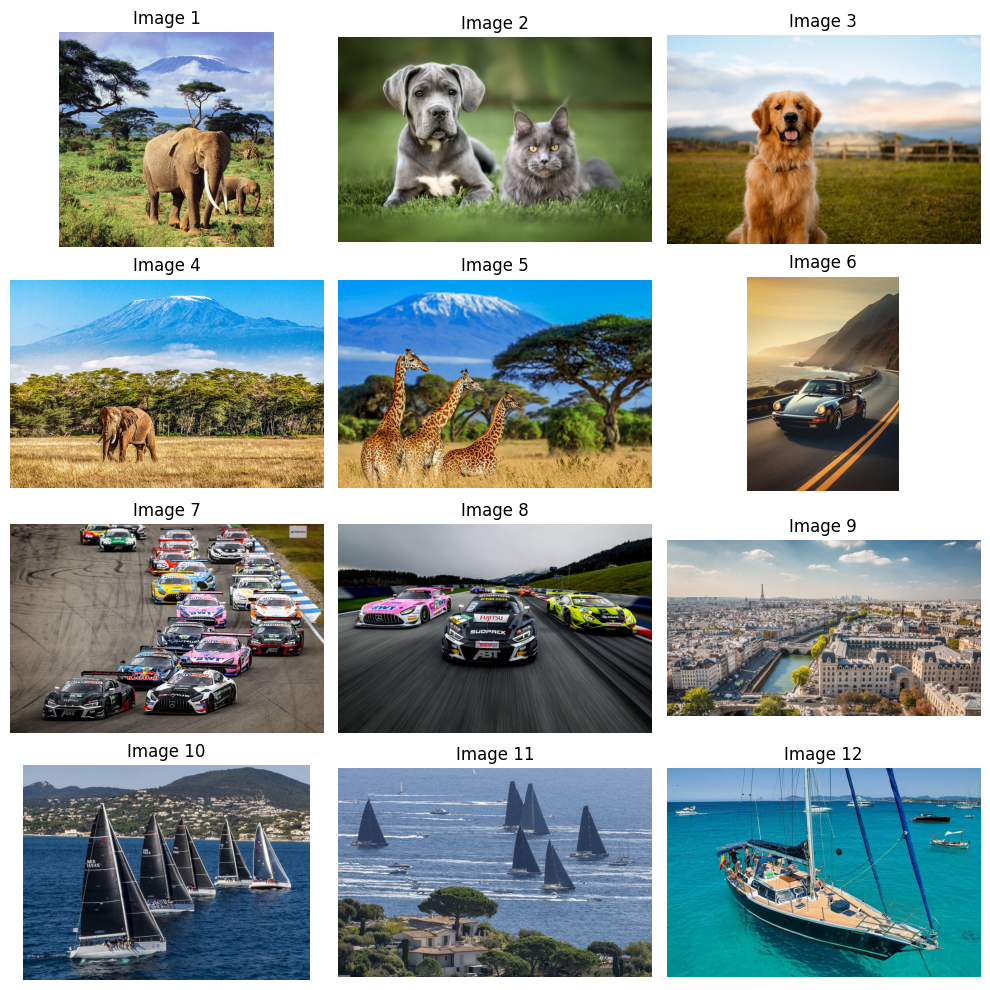

In [7]:
show_images(images)

In [8]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [9]:
# Choose Resnet50 pretrained on ImageNet
model = models.inception_v3(weights=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Load class labels
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('/content/drive/MyDrive/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [11]:
# Funtion for getting predictions on sample images
def get_predictions(model, img):
    # Get input tensor
    img_t = get_input_tensors(img)

    # Make prediction
    model.eval()
    logits = model(img_t)

    # Get probabilities and top 5 predictions
    probs = F.softmax(logits, dim=1)
    probs5 = probs.topk(5)

    # Convert logits to probabilities and get class labels
    predictions = [(p.item(), c.item(), idx2label[c.item()]) for p, c in zip(probs5[0][0], probs5[1][0])]

    return predictions

In [12]:
# Predictions for the first image
for i in range(len(images)):
  predictions_img = get_predictions(model, images[i])
  print(predictions_img)

[(0.9998726844787598, 386, 'African_elephant'), (0.00011980221461271867, 101, 'tusker'), (6.493484761449508e-06, 385, 'Indian_elephant'), (3.3463820159340685e-07, 684, 'ocarina'), (4.255263164054668e-08, 755, 'radio_telescope')]
[(0.8781170845031738, 246, 'Great_Dane'), (0.12180611491203308, 178, 'Weimaraner'), (1.004045316221891e-05, 180, 'American_Staffordshire_terrier'), (9.211731594405137e-06, 243, 'bull_mastiff'), (6.205058525665663e-06, 208, 'Labrador_retriever')]
[(0.9978173971176147, 207, 'golden_retriever'), (0.002073543146252632, 208, 'Labrador_retriever'), (1.562223224027548e-05, 256, 'Newfoundland'), (1.2986944057047367e-05, 257, 'Great_Pyrenees'), (1.2724208318104502e-05, 222, 'kuvasz')]
[(0.6507673263549805, 980, 'volcano'), (0.27903974056243896, 385, 'Indian_elephant'), (0.06695842742919922, 386, 'African_elephant'), (0.0030672717839479446, 101, 'tusker'), (3.8684414903400466e-05, 677, 'nail')]
[(0.6744614839553833, 51, 'triceratops'), (0.10978982597589493, 355, 'llama')

In [13]:
# Function for transforming images to size 224 x 224
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

# Function for converting images to tensor and normalizing pixel values
def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

In [14]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [15]:
# Function for getting predictions on sample images
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [16]:
test_preds = batch_predict([pill_transf(img) for img in images])
test_preds.argmax(axis=1)

array([386, 246, 207, 980,  51, 817, 468, 751, 858, 484, 780, 625])

In [18]:
# Generate Lime explanations for each image
def generate_lime_explanations(images, batch_predict, top_labels=5, hide_color=0, num_samples=1000):
  explanations = []
  explainer = lime_image.LimeImageExplainer()

  for img in images:
    explanation = explainer.explain_instance(np.array(img),
                                             batch_predict,
                                             top_labels=top_labels,
                                             hide_color=hide_color,
                                             num_samples=num_samples)
    explanations.append(explanation)

  return explanations

In [17]:
# Generate Lime explanations image
def generate_lime_explanation(image, batch_predict, top_labels=5, hide_color=0, num_samples=1000):
  explainer = lime_image.LimeImageExplainer()

  explanation = explainer.explain_instance(np.array(pill_transf(image)),
                                            batch_predict,
                                            top_labels=top_labels,
                                            hide_color=hide_color,
                                            num_samples=num_samples)

  return explanation

In [19]:
explanation = generate_lime_explanation(images[0], batch_predict)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
explanations = []
for img in images:
  explanations.append(generate_lime_explanation(img, batch_predict))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [58]:
# Choose example explantation
explanation = explanations[11]

In [50]:
# Compare with actual class
print(explanation.top_labels[0])

858


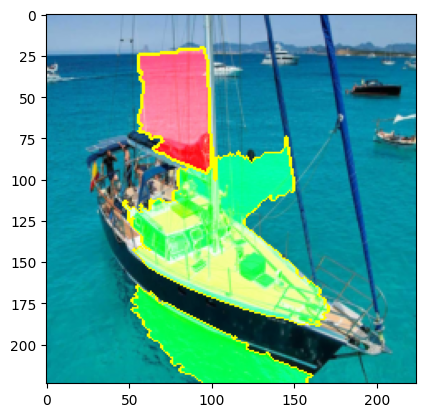

In [59]:
# Show explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [56]:
# Function for displaying all explanations
def show_explanations():
  num_images = len(explanations)
  num_cols = 4
  num_rows = (num_images + num_cols - 1) // num_cols

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

  for i, (explanation, img) in enumerate(zip(explanations, images)):
      row = i // num_cols
      col = i % num_cols

      temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

      img_boundry = mark_boundaries(temp / 255.0, mask)

      axes[row, col].imshow(img_boundry)
      axes[row, col].set_title(f'Image {i+1}')
      axes[row, col].axis('off')

  plt.tight_layout()
  plt.show()

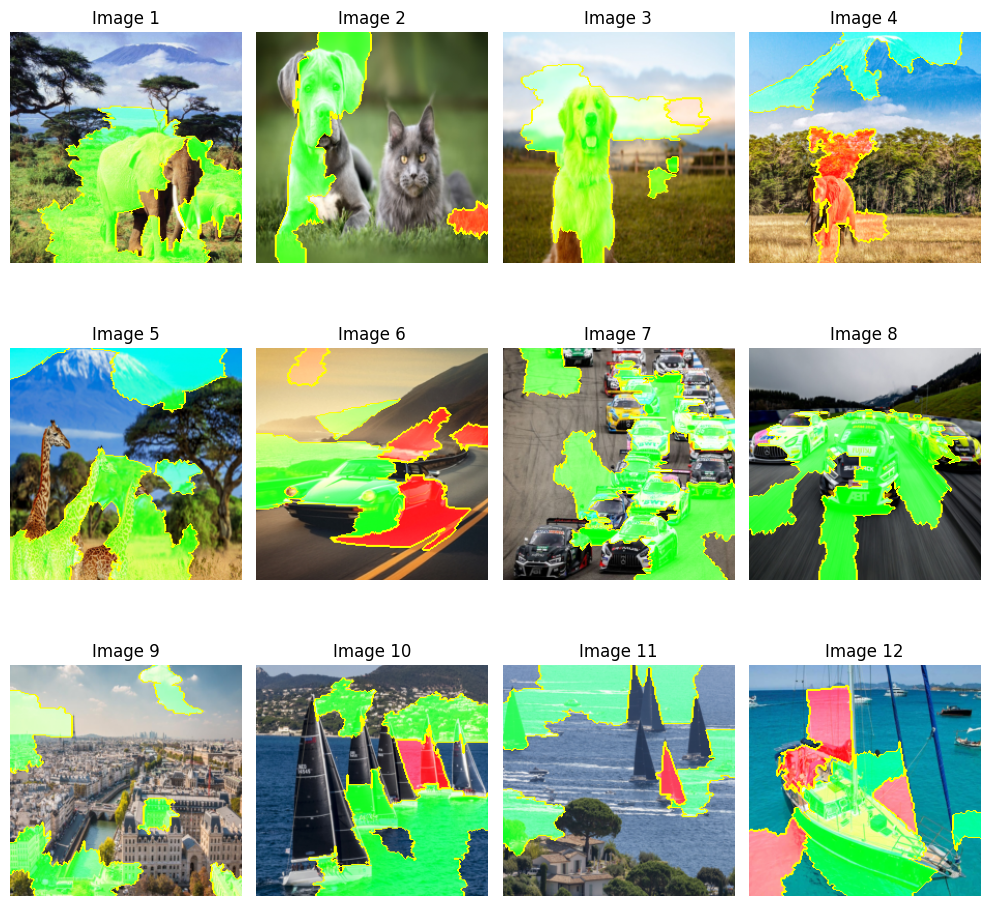

In [57]:
show_explanations()